In [1]:
!pip install scikit-learn xgboost lightgbm catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.3 MB/s eta 0:00:00


In [1]:
import sklearn
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

In [4]:
df = pd.read_csv('Confocal Raman Data/s.csv')

In [5]:
mapping = {"Mild": 0, "Moderate": 1, "Severe": 2}
df['Severity'] = df['Severity'].replace(mapping)
df.head()

,Severity,Subject,Ceramide,Lactic Acid,PCA,Uric Acid,Urea,Melanin,chol
0,2,EC001,0.251417,5263.565519,2039.315078,111.788984,535.868202,100700.069100,83.034163
1,2,EC002,0.683433,3.401875,1.362861,0.022682,0.341596,29.113241,0.106501
2,2,EC003,1.032862,2.477007,1.524537,0.021377,0.194330,85.875953,0.169743
3,2,EC004,0.936938,3.802298,3.126483,0.015471,0.409775,172.254982,0.108228
4,2,EC006,3.527008,2.499475,1.071707,0.002790,0.003685,4.296232,0.129945


In [6]:
X = df.drop("Subject", axis=1).drop("Severity", axis=1)
y = df['Severity']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [8]:
len(X_train)

35

In [18]:
len(X_test)

7

In [73]:
import skopt
from skopt import BayesSearchCV
classifiers = {
    'Random Forest': (RandomForestClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }),
    'K-Nearest Neighbors': (KNeighborsClassifier(), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }),
    'Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [None, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }),
    'AdaBoost': (AdaBoostClassifier(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001]
    }),
    'XGBoost': (xgb.XGBClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }),
    'LightGBM': (lgb.LGBMClassifier(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.1, 0.01, 0.001],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
    }),
    'CatBoost': (CatBoostClassifier(silent=True), {
        'iterations': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001],
        'depth': [3, 5, 7],
    }),
}

for clf_name, (clf, param_bayes) in classifiers.items():
    bayes_search = BayesSearchCV(clf, param_bayes, cv=5)
    bayes_search.fit(X_train, y_train)

    best_score = bayes_search.best_score_
    best_params = bayes_search.best_params_

    print(f"Results for {clf_name}:")
    print("Best cross-validation accuracy:", best_score)
    print("Best hyperparameters:", best_params)
    print("-----------------------------------")
    
    best_model = bayes_search.best_estimator_
    test_score = best_model.score(X_test, y_test)
    print("Test accuracy:", test_score)
    print("-----------------------------------")

    y_pred = best_model.predict(X_test)
    print(sklearn.metrics.classification_report(y_test, y_pred))


C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for Random Forest:
Best cross-validation accuracy: 0.5199999999999999
Best hyperparameters: OrderedDict([('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 2), ('n_estimators', 50)])
-----------------------------------
Test accuracy: 0.38461538461538464
-----------------------------------
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.50      0.50      0.50         8
           2       0.00      0.00      0.00         4

    accuracy                           0.38        13
   macro avg       0.25      0.50      0.30        13
weighted avg       0.33      0.38      0.34        13



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for K-Nearest Neighbors:
Best cross-validation accuracy: 0.48
Best hyperparameters: OrderedDict([('algorithm', 'ball_tree'), ('n_neighbors', 5), ('weights', 'uniform')])
-----------------------------------
Test accuracy: 0.46153846153846156
-----------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.55      0.75      0.63         8
           2       0.00      0.00      0.00         4

    accuracy                           0.46        13
   macro avg       0.18      0.25      0.21        13
weighted avg       0.34      0.46      0.39        13



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for Decision Tree:
Best cross-validation accuracy: 0.5466666666666666
Best hyperparameters: OrderedDict([('max_depth', 5), ('max_features', 'log2'), ('min_samples_leaf', 2)])
-----------------------------------
Test accuracy: 0.3076923076923077
-----------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.43      0.38      0.40         8
           2       1.00      0.25      0.40         4

    accuracy                           0.31        13
   macro avg       0.48      0.21      0.27        13
weighted avg       0.57      0.31      0.37        13



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\

Results for AdaBoost:
Best cross-validation accuracy: 0.5133333333333333
Best hyperparameters: OrderedDict([('learning_rate', 0.01), ('n_estimators', 100)])
-----------------------------------
Test accuracy: 0.23076923076923078
-----------------------------------
              precision    recall  f1-score   support

           0       0.25      1.00      0.40         1
           1       0.40      0.25      0.31         8
           2       0.00      0.00      0.00         4

    accuracy                           0.23        13
   macro avg       0.22      0.42      0.24        13
weighted avg       0.27      0.23      0.22        13



C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Results for XGBoost:
Best cross-validation accuracy: 0.48
Best hyperparameters: OrderedDict([('colsample_bytree', 0.8065271885365701), ('learning_rate', 0.001), ('max_depth', 7), ('n_estimators', 50), ('subsample', 0.8)])
-----------------------------------
Test accuracy: 0.46153846153846156
-----------------------------------
              precision    recall  f1-score   support

           0       0.33      1.00      0.50         1
           1       0.56      0.62      0.59         8
           2       0.00      0.00      0.00         4

    accuracy                           0.46        13
   macro avg       0.30      0.54      0.36        13
weighted avg       0.37      0.46      0.40        13

Results for LightGBM:
Best cross-validation accuracy: 0.5533333333333333
Best hyperparameters: OrderedDict([('colsample_bytree', 0.9263569975753607), ('learning_rate', 0.1), ('max_depth', 5), ('n_estimators', 100), ('subsample', 0.833780874249106)])
-----------------------------------
Test

C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\skopt\optimi

Results for CatBoost:
Best cross-validation accuracy: 0.5533333333333333
Best hyperparameters: OrderedDict([('depth', 3), ('iterations', 50), ('learning_rate', 0.001)])
-----------------------------------
Test accuracy: 0.6153846153846154
-----------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.62      1.00      0.76         8
           2       0.00      0.00      0.00         4

    accuracy                           0.62        13
   macro avg       0.21      0.33      0.25        13
weighted avg       0.38      0.62      0.47        13



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
estimators = [(name, clf) for name, (clf, _) in classifiers.items()]
stacking_clf = StackingClassifier(estimators=estimators)
stacking_clf.fit(X_train, y_train)

bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)
bagging_clf.fit(X_train, y_train)

C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)

In [75]:
y_pred = bagging_clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      1.00      0.33         1
           1       0.60      0.38      0.46         8
           2       0.33      0.25      0.29         4

    accuracy                           0.38        13
   macro avg       0.38      0.54      0.36        13
weighted avg       0.49      0.38      0.40        13



In [76]:
y_pred = stacking_clf.predict(X_test)
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.64      0.88      0.74         8
           2       0.00      0.00      0.00         4

    accuracy                           0.54        13
   macro avg       0.21      0.29      0.25        13
weighted avg       0.39      0.54      0.45        13



C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Mahir\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [70]:
import numpy as np
feature_importances = np.mean([
    tree.feature_importances_ for tree in bagging_clf.estimators_
], axis=0)

<Axes: title={'center': 'Feature Importance of Bagging Classifier'}, xlabel='Features', ylabel='Feature Importance'>

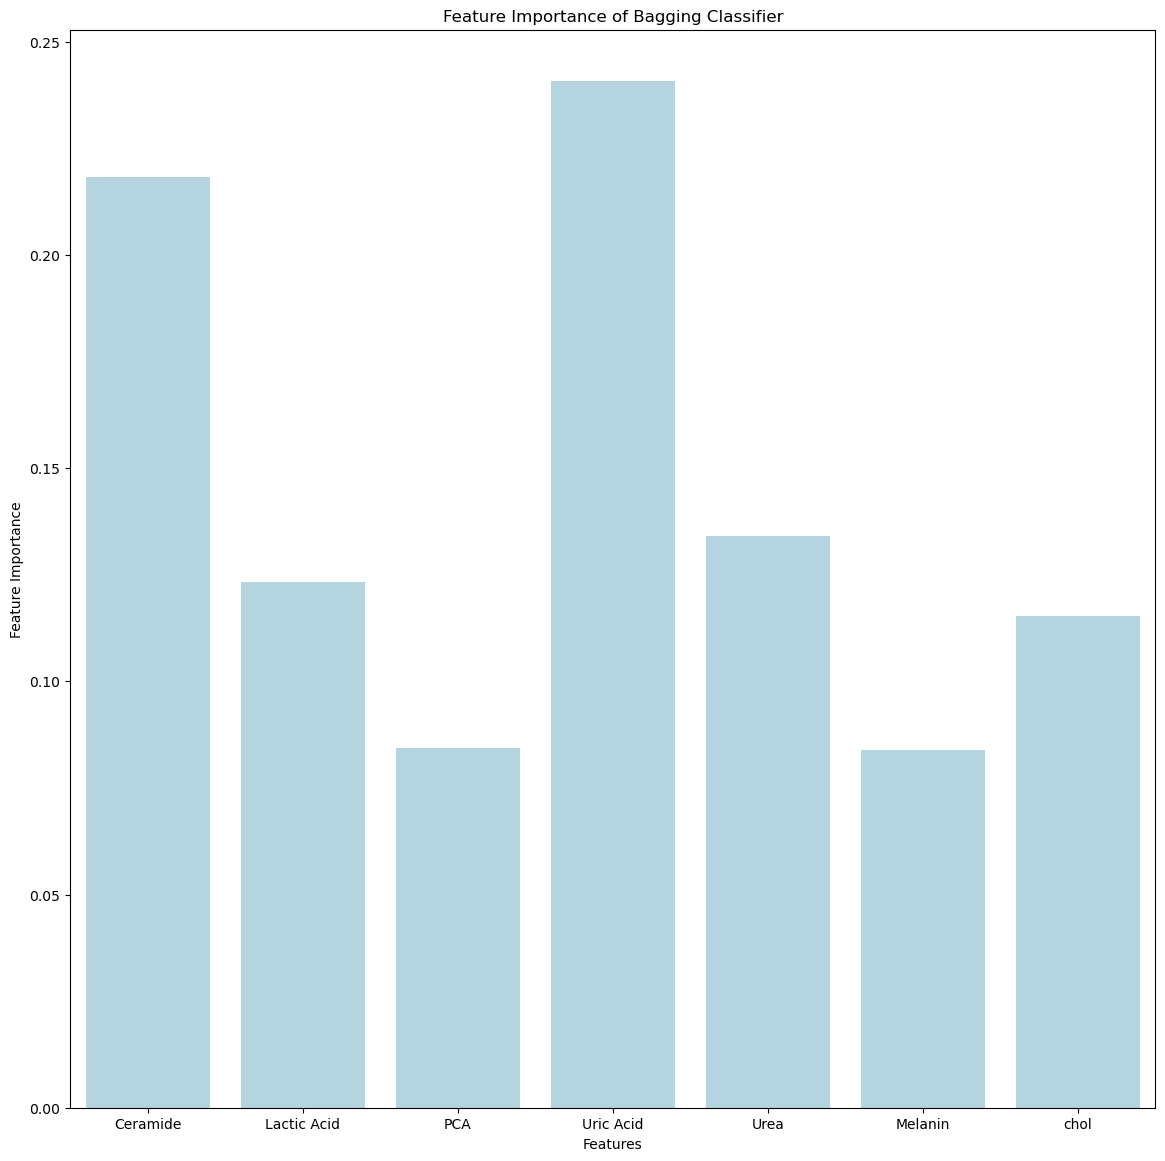

In [71]:
import matplotlib.pyplot
import seaborn as sns

plt.figure(figsize=(14, 14))
plt.xlabel('Features')
plt.ylabel('Feature Importance')
plt.title('Feature Importance of Bagging Classifier')
sns.barplot(y=feature_importances, x=X.columns, color='b', palette=['lightblue'])